# Imports

In [1]:
import shap
import optuna

import numpy   as np
import pandas  as pd
import seaborn as sns
import category_encoders as ce

import matplotlib.pyplot as plt

from xgboost  import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from feature_engine import encoding
from feature_engine import creation
from feature_engine import selection
from feature_engine import imputation

from sklearn.metrics           import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Functions

In [2]:
random_state = 42
np.random.seed(random_state)

In [3]:
def jupyter_settings():
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 500

jupyter_settings()

In [4]:
def get_metrics(y_true, y_pred):

    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"R2: {r2}; RMSE: {rmse}; MAE: {mae}; MAPE: {mape}")

# Loading Datasets

In [5]:
df_train = pd.read_parquet('../data/processed/V0.1_dataframe_train.parquet')
df_valid = pd.read_parquet('../data/processed/V0.1_dataframe_valid.parquet')
df_oot = pd.read_parquet('../data/processed/V0.1_dataframe_oot.parquet')

## Columns

In [6]:
df_train.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

In [7]:
df_valid.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

In [8]:
df_oot.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

## Data Dimensions

In [9]:
print('Number of Rows: {}'.format(df_train.shape[0]))
print('Number of Cols: {}'.format(df_train.shape[1]))

Number of Rows: 52161
Number of Cols: 147


In [10]:
print('Number of Rows: {}'.format(df_valid.shape[0]))
print('Number of Cols: {}'.format(df_valid.shape[1]))

Number of Rows: 25692
Number of Cols: 147


In [11]:
print('Number of Rows: {}'.format(df_oot.shape[0]))
print('Number of Cols: {}'.format(df_oot.shape[1]))

Number of Rows: 18603
Number of Cols: 147


## Data Types

In [12]:
df_train.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

In [13]:
df_valid.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

In [14]:
df_oot.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

## Check NA

In [15]:
df_train.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002799
customer_lng                                0.002799
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.002492
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.002511
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.005272
distance_customer_seller_max                0.

In [16]:
df_valid.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002491
customer_lng                                0.002491
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.002335
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.002335
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.004787
distance_customer_seller_max                0.

In [17]:
df_oot.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002903
customer_lng                                0.002903
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.001398
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.001398
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.004193
distance_customer_seller_max                0.

## Splitting into X and y

In [18]:
list_columns = [
    'order_purchase_timestamp', 'order_delivered_customer_date', 
    'order_estimated_delivery_date', 'delivered_in_days', 'estimated_delivery_in_days', 'time']

X_train = df_train.drop(columns=list_columns)
X_valid = df_valid.drop(columns=list_columns)
X_oot = df_oot.drop(columns=list_columns)

In [19]:
target = 'delivered_in_days'
list_columns = ['delivered_in_days', 'estimated_delivery_in_days']

y_train = df_train.loc[:, list_columns]
y_valid = df_valid.loc[:, list_columns]
y_oot = df_oot.loc[:, list_columns]

# Feature Engineering

## Fill NA

In [20]:
categorical_variables = X_train.select_dtypes(include='object').columns.tolist()

In [21]:
cat_imputer = imputation.CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=categorical_variables)
X_train = cat_imputer.fit_transform(X_train)
X_valid = cat_imputer.transform(X_valid)
X_oot = cat_imputer.transform(X_oot)

## Categorical Encoding

In [22]:
cat_imputer = imputation.CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=categorical_variables)

X_train = cat_imputer.fit_transform(X_train)
X_valid = cat_imputer.fit_transform(X_valid)
X_oot = cat_imputer.fit_transform(X_oot)

In [23]:
rare_label_encoder = encoding.RareLabelEncoder(variables=categorical_variables)

X_train = rare_label_encoder.fit_transform(X_train)
X_valid = rare_label_encoder.transform(X_valid)
X_oot = rare_label_encoder.transform(X_oot)

The number of unique categories for variable payment_type_mode is less than that indicated in n_categories. Thus, all categories will be considered frequent


In [24]:
count_encoder = ce.CountEncoder(
    cols=None, return_df=True, handle_unknown='value', 
    handle_missing='value', normalize=True)

X_train[[c + '_ce' for c in categorical_variables]] = count_encoder.fit_transform(X_train[categorical_variables])
X_valid[[c + '_ce' for c in categorical_variables]] = count_encoder.transform(X_valid[categorical_variables])
X_oot[[c + '_ce' for c in categorical_variables]] = count_encoder.transform(X_oot[categorical_variables])

In [25]:
target_encoder = ce.TargetEncoder(
    cols=None, return_df=False, handle_missing='value', handle_unknown='value')

X_train[[c + '_te' for c in categorical_variables]] = target_encoder.fit_transform(X_train[categorical_variables], y_train[target])
X_valid[[c + '_te' for c in categorical_variables]] = target_encoder.transform(X_valid[categorical_variables])
X_oot[[c + '_te' for c in categorical_variables]] = target_encoder.transform(X_oot[categorical_variables])

## Cyclical Features

In [26]:
cyclical_variables = [
    'order_purchase_timestamp_second', 'order_purchase_timestamp_minute', 'order_purchase_timestamp_hour', 'order_purchase_timestamp_day', 'order_purchase_timestamp_month',
    'order_approved_at_second', 'order_approved_at_minute', 'order_approved_at_hour', 'order_approved_at_day', 'order_approved_at_month']

cyclical_features = creation.CyclicalFeatures(variables=cyclical_variables, max_values=None, drop_original=False)
X_train = cyclical_features.fit_transform(X_train)
X_valid = cyclical_features.transform(X_valid)
X_oot = cyclical_features.transform(X_oot)

## Removing Features

In [27]:
drop_constant_features = selection.DropConstantFeatures(tol=.9, missing_values='include')
X_train = drop_constant_features.fit_transform(X_train)
X_valid = drop_constant_features.transform(X_valid)
X_oot = drop_constant_features.transform(X_oot)

# Machine Learning Modeling

## LightGBM Regressor

### First Hyperparameter Tuning

In [28]:
categorical_columns = X_train.select_dtypes(include='object').columns.tolist()

X_train[categorical_columns] = X_train[categorical_columns].astype('category')
X_valid[categorical_columns] = X_valid[categorical_columns].astype('category')
X_oot[categorical_columns] = X_oot[categorical_columns].astype('category')

In [29]:
def objective(trial):
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "bagging_freq": 1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train[target], eval_set=[(X_valid, y_valid[target])])
    
    pred = model.predict(X_valid)
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 900, 'learning_rate': 0.010423082977551295, 'num_leaves': 483, 'subsample': 0.9973738235367293, 'colsample_bytree': 0.29069604209315736, 'min_data_in_leaf': 89}
Best RMSE: 7.959021074641135


In [29]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_estimators': 1100, 
    'learning_rate': 0.011378717939855917, 
    'num_leaves': 427, 
    'subsample': 0.4579686295441284, 
    'colsample_bytree': 0.7399913971559565, 
    'min_data_in_leaf': 61}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train, y_train[target], eval_set=[(X_valid, y_valid[target])])

y_train['pred'] = lgbm.predict(X_train)
get_metrics(y_train[target], y_train['pred'])

R2: 0.6728781531937398; RMSE: 5.751133988677527; MAE: 3.2097908244104363; MAPE: 11042359601898.428


In [30]:
y_valid['pred'] = lgbm.predict(X_valid)
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.33817845784683465; RMSE: 8.005861698807095; MAE: 4.946510480660707; MAPE: 16438778518079.934


In [31]:
y_oot['pred'] = lgbm.predict(X_oot)
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.01719393884269138; RMSE: 5.856673421212382; MAE: 4.412780737285608; MAPE: 113331288272879.22


### Feature Selection

In [32]:
smart_correlation_selection = selection.SmartCorrelatedSelection(
    estimator=LGBMRegressor(**params), method='pearson', threshold=0.8, missing_values='ignore', 
    selection_method='model_performance', scoring='r2', cv=3)

smart_correlation_selection.fit(X_train, y_train[target])
features_to_drop = smart_correlation_selection.features_to_drop_

In [33]:
sfm = SelectFromModel(estimator=LGBMRegressor(**params))
sfm.fit(X_train.drop(features_to_drop, axis=1), y_train[target])

SelectFromModel(estimator=LGBMRegressor(bagging_freq=1,
                                        colsample_bytree=0.7399913971559565,
                                        learning_rate=0.011378717939855917,
                                        metric='rmse', min_data_in_leaf=61,
                                        n_estimators=1100, num_leaves=427,
                                        objective='regression',
                                        subsample=0.4579686295441284,
                                        verbosity=-1))

In [34]:
list_selected_features = X_train.drop(features_to_drop, axis=1).loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_lat',
 'customer_lng',
 'distance_customer_seller_min',
 'payment_value_median',
 'freight_value_q25',
 'product_name_lenght_q25',
 'product_description_lenght_max',
 'product_weight_g_q25',
 'product_length_cm_q25',
 'product_height_cm_q25',
 'product_width_cm_mean',
 'order_purchase_timestamp_second',
 'order_purchase_timestamp_minute',
 'order_approved_at_second',
 'order_approved_at_minute',
 'order_approved_at_month',
 'order_purchase_timestamp_second_sin',
 'order_purchase_timestamp_second_cos',
 'order_purchase_timestamp_minute_sin',
 'order_purchase_timestamp_minute_cos',
 'order_purchase_timestamp_day_sin',
 'order_purchase_timestamp_day_cos',
 'order_approved_at_second_cos',
 'order_approved_at_minute_cos',
 'order_approved_at_day_sin',
 'order_approved_at_month_cos']

In [35]:
lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.6348625210701231; RMSE: 6.076128046004545; MAE: 3.4879302882248377; MAPE: 13229241891689.102


In [36]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3200246039464133; RMSE: 8.114919819959132; MAE: 5.040551831637703; MAPE: 18116873582724.41


In [37]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.03943614416359775; RMSE: 5.920358872573379; MAE: 4.485979819157268; MAPE: 112070410889769.4


### Second Hyperparamenter Tuning

In [39]:
def objective(trial):
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "bagging_freq": 1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = LGBMRegressor(**params)
    model.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])
    
    pred = model.predict(X_valid[list_selected_features])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 400, 'learning_rate': 0.020382096788539916, 'num_leaves': 244, 'subsample': 0.8154087943605954, 'colsample_bytree': 0.5830110427083977, 'min_data_in_leaf': 70}
Best RMSE: 8.063905787150599


In [38]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_estimators': 900, 
    'learning_rate': 0.008118480150159538, 
    'num_leaves': 688, 
    'subsample': 0.9353531783366564, 
    'colsample_bytree': 0.7738499976876134, 
    'min_data_in_leaf': 59}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.6978021956639224; RMSE: 5.527698707784576; MAE: 3.0920630972896177; MAPE: 11495817118699.531


In [39]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3281680481669794; RMSE: 8.066180964022717; MAE: 4.988865654969408; MAPE: 17326268042920.322


In [40]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.02495971288005361; RMSE: 5.878987319800829; MAE: 4.455255133836068; MAPE: 113874331410879.48


## CatBoost Regressor

### First Hyperparameter Tuning

In [76]:
def objective(trial):
    
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train[target], eval_set=(X_valid, y_valid[target]), cat_features=categorical_columns)
    
    pred = model.predict(X_valid)
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.049147652406925736, 'depth': 8, 'subsample': 0.9036551832381197, 'colsample_bylevel': 0.917615199466539, 'min_data_in_leaf': 32}
Best RMSE: 8.053795066486012


In [41]:
params = {
    "iterations": 1000,
    'learning_rate': 0.049147652406925736, 
    'depth': 8, 
    'subsample': 0.9036551832381197, 
    'colsample_bylevel': 0.917615199466539, 
    'min_data_in_leaf': 32}

cat = CatBoostRegressor(**params, silent=True)
cat.fit(X_train, y_train[target], eval_set=(X_valid, y_valid[target]), cat_features=categorical_columns)

y_train['pred'] = cat.predict(X_train)
get_metrics(y_train[target], y_train['pred'])

R2: 0.5034711810750512; RMSE: 7.08550716087213; MAE: 4.563275947641302; MAPE: 16917190367621.32


In [42]:
y_valid['pred'] = cat.predict(X_valid)
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3302297060886995; RMSE: 8.053795066486012; MAE: 4.988417447703706; MAPE: 14702599834413.18


In [43]:
y_oot['pred'] = cat.predict(X_oot)
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.03686249757026927; RMSE: 5.698929344830773; MAE: 4.282255209953718; MAPE: 111157168787108.56


### Feature Selection

In [44]:
smart_correlation_selection = selection.SmartCorrelatedSelection(
    estimator=CatBoostRegressor(**params, silent=True), method='pearson', threshold=0.8, missing_values='ignore', 
    selection_method='model_performance', scoring='r2', cv=3)

smart_correlation_selection.fit(X_train, y_train[target])
features_to_drop = smart_correlation_selection.features_to_drop_

In [45]:
categorical_columns = X_train.drop(features_to_drop, axis=1).select_dtypes(include='category').columns.tolist()

sfm = SelectFromModel(estimator=CatBoostRegressor(**params, silent=True))
sfm.fit(X_train.drop(features_to_drop, axis=1), y_train[target], cat_features=categorical_columns)

SelectFromModel(estimator=<catboost.core.CatBoostRegressor object at 0x7f6025950280>)

In [46]:
list_selected_features = X_train.drop(features_to_drop, axis=1).loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_state',
 'customer_lat',
 'customer_lng',
 'distance_customer_seller_min',
 'freight_value_mean',
 'product_description_lenght_min',
 'product_weight_g_median',
 'product_length_cm_min',
 'product_height_cm_q25',
 'product_width_cm_median',
 'order_approved_at_month',
 'customer_state_te',
 'order_approved_at_day_sin',
 'order_approved_at_month_sin',
 'order_approved_at_month_cos']

In [47]:
cat = CatBoostRegressor(**params, silent=True)
cat.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], cat_features=['customer_state'])

y_train['pred'] = cat.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.4890050805174143; RMSE: 7.187982353076853; MAE: 4.592832928639535; MAPE: 20659511235101.96


In [48]:
y_valid['pred'] = cat.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.32209574033182176; RMSE: 8.102551781706396; MAE: 5.030642195062608; MAPE: 17046707816620.47


In [49]:
y_oot['pred'] = cat.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.028007982851345647; RMSE: 5.725065699195492; MAE: 4.315407505841507; MAPE: 119781265632827.89


### Second Hyperparameter Tuning

In [67]:
def objective(trial):
    
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train[list_selected_features], y_train[target], eval_set=(X_valid[list_selected_features], y_valid[target]), cat_features=['customer_state'])
    
    pred = model.predict(X_valid[list_selected_features])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.05351881469428861, 'depth': 9, 'subsample': 0.9516550467115146, 'colsample_bylevel': 0.27094725636766614, 'min_data_in_leaf': 53}
Best RMSE: 8.081444359712796


In [50]:
params = {
    'iterations': 1000,
    'learning_rate': 0.05351881469428861, 
    'depth': 9, 
    'subsample': 0.9516550467115146, 
    'colsample_bylevel': 0.27094725636766614, 
    'min_data_in_leaf': 53}

cat = CatBoostRegressor(**params, silent=True)
cat.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], cat_features=['customer_state'])

y_train['pred'] = cat.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5408639483051971; RMSE: 6.813486640530221; MAE: 4.348018743305445; MAPE: 19309647298421.598


In [51]:
y_valid['pred'] = cat.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3256230670792244; RMSE: 8.081444359712796; MAE: 5.0086528709622025; MAPE: 17684597549739.27


In [52]:
y_oot['pred'] = cat.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.007783406341990151; RMSE: 5.784320769106498; MAE: 4.366519553256405; MAPE: 117310934663513.48


## XGBoost Regressor

### First Hyperparameter Tuning

In [64]:
def objective(trial):
    
    params = {
        "enable_categorical": True,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20)}

    model = XGBRegressor(**params)
    model.fit(X_train, y_train[target], eval_set=[(X_valid, y_valid[target])], verbose=False)
    
    pred = model.predict(X_valid)
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 900, 'learning_rate': 0.022673068248214003, 'max_depth': 9, 'subsample': 0.8722490606664792, 'colsample_bytree': 0.29378036508860195, 'min_child_weight': 14}
Best RMSE: 8.009021217419246


In [69]:
params = {
    'enable_categorical': True,
    'n_estimators': 900, 
    'learning_rate': 0.022673068248214003, 
    'max_depth': 9, 
    'subsample': 0.8722490606664792, 
    'colsample_bytree': 0.29378036508860195, 
    'min_child_weight': 14}

xgb = XGBRegressor(**params)
xgb.fit(X_train, y_train[target], eval_set=[(X_valid, y_valid[target])], verbose=False)

y_train['pred'] = xgb.predict(X_train)
get_metrics(y_train[target], y_train['pred'])

R2: 0.7430105293934549; RMSE: 5.097489923782381; MAE: 3.2064325179608955; MAPE: 10365496999388.264


In [71]:
y_valid['pred'] = xgb.predict(X_valid)
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.33765597815040693; RMSE: 8.009021217419246; MAE: 4.9638183547212; MAPE: 15785667750180.973


In [72]:
y_oot['pred'] = xgb.predict(X_oot)
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.009679510423542537; RMSE: 5.835000497161472; MAE: 4.393491828780607; MAPE: 116191188135825.69


### Feature Selecion

In [73]:
smart_correlation_selection = selection.SmartCorrelatedSelection(
    estimator=XGBRegressor(**params), method='pearson', threshold=0.8, missing_values='ignore', 
    selection_method='model_performance', scoring='r2', cv=3)

smart_correlation_selection.fit(X_train, y_train[target])
features_to_drop = smart_correlation_selection.features_to_drop_

In [75]:
categorical_columns = X_train.drop(features_to_drop, axis=1).select_dtypes(include='category').columns.tolist()

sfm = SelectFromModel(estimator=XGBRegressor(**params))
sfm.fit(X_train.drop(features_to_drop, axis=1), y_train[target])

SelectFromModel(estimator=XGBRegressor(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=0.29378036508860195,
                                       device=None, early_stopping_rounds=None,
                                       enable_categorical=True,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=0.022673068248214003,
                                       max_bin=None, max_cat_threshold=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max_depth=9,
                                       max_leaves=None, min_child_weight=14,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=900,
                                       n_jobs=None, num_parallel_tree=None,
                                       random_state=None, ...))

In [76]:
list_selected_features = X_train.drop(features_to_drop, axis=1).loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_state_mode',
 'distance_customer_seller_min',
 'freight_value_mean',
 'order_approved_at_month',
 'customer_city_ce',
 'customer_state_ce',
 'seller_geolocation_city_mode_ce',
 'customer_state_te',
 'seller_geolocation_state_mode_te',
 'order_approved_at_month_cos']

In [78]:
xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], verbose=False)

y_train['pred'] = xgb.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.46893962125228195; RMSE: 7.327750293629124; MAE: 4.555302243796675; MAPE: 23000141054901.434


In [79]:
y_valid['pred'] = xgb.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.30451018696667753; RMSE: 8.206973297091318; MAE: 5.11720994253146; MAPE: 21260864626297.05


In [84]:
y_oot['pred'] = xgb.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.034423400329695486; RMSE: 5.9060659748269275; MAE: 4.398963032964288; MAPE: 109657702666830.3


### Second Hyperparameter Tuning

In [85]:
def objective(trial):
    
    params = {
        "enable_categorical": True,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20)}

    model = XGBRegressor(**params)
    model.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], verbose=False)
    
    pred = model.predict(X_valid[list_selected_features])
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 800, 'learning_rate': 0.007674734855922525, 'max_depth': 10, 'subsample': 0.756637970016439, 'colsample_bytree': 0.5108703994958398, 'min_child_weight': 17}
Best RMSE: 8.161264944641328


In [86]:
params = {
    'enable_categorical': True,
    'n_estimators': 800, 
    'learning_rate': 0.007674734855922525, 
    'max_depth': 10, 
    'subsample': 0.756637970016439, 
    'colsample_bytree': 0.5108703994958398, 
    'min_child_weight': 17}

xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])], verbose=False)

y_train['pred'] = xgb.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.44348514445448484; RMSE: 7.501309628412448; MAE: 4.62165278206962; MAPE: 23232413698970.703


In [87]:
y_valid['pred'] = xgb.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3122356094212748; RMSE: 8.161264944641328; MAE: 5.0762969250529055; MAPE: 20974213757951.164


In [88]:
y_oot['pred'] = xgb.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.002247653541174177; RMSE: 5.8134862536813365; MAE: 4.379636402688398; MAPE: 113757715202889.08


# Result Analysis

## Final Model

In [92]:
list_selected_columns = [
    'customer_lat',
    'customer_lng',
    'distance_customer_seller_min',
    'payment_value_median',
    'freight_value_q25',
    'product_name_lenght_q25',
    'product_description_lenght_max',
    'product_weight_g_q25',
    'product_length_cm_q25',
    'product_height_cm_q25',
    'product_width_cm_mean',
    'order_purchase_timestamp_second',
    'order_purchase_timestamp_minute',
    'order_approved_at_second',
    'order_approved_at_minute',
    'order_approved_at_month',
    'order_purchase_timestamp_second_sin',
    'order_purchase_timestamp_second_cos',
    'order_purchase_timestamp_minute_sin',
    'order_purchase_timestamp_minute_cos',
    'order_purchase_timestamp_day_sin',
    'order_purchase_timestamp_day_cos',
    'order_approved_at_second_cos',
    'order_approved_at_minute_cos',
    'order_approved_at_day_sin',
    'order_approved_at_month_cos']

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_estimators': 900, 
    'learning_rate': 0.008118480150159538, 
    'num_leaves': 688, 
    'subsample': 0.9353531783366564, 
    'colsample_bytree': 0.7738499976876134, 
    'min_data_in_leaf': 59}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.5348968373281158; RMSE: 6.857619076069917; MAE: 4.105505814755573; MAPE: 18690993962939.848


In [93]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3017741896105808; RMSE: 8.223100217192222; MAE: 5.127473484280988; MAPE: 19567894489053.703


In [94]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.03659353703464929; RMSE: 5.91225795354172; MAE: 4.426038874551464; MAPE: 112669398398553.16


### Feature Importances

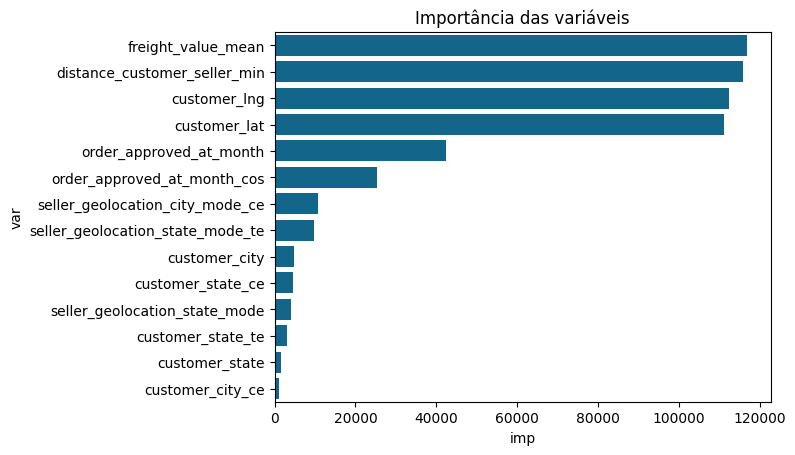

In [98]:
imp = pd.DataFrame(lgbm.feature_importances_, X_train[list_selected_features].columns).reset_index()
imp.columns = ["var", "imp"]
imp = imp.sort_values("imp", ascending=False)

sns.barplot(x="imp", y="var", color="#006e9cff", data=imp.iloc[:30])

plt.title(f"Importância das variáveis")
plt.show()

### Shap Values

In [96]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train[list_selected_features])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


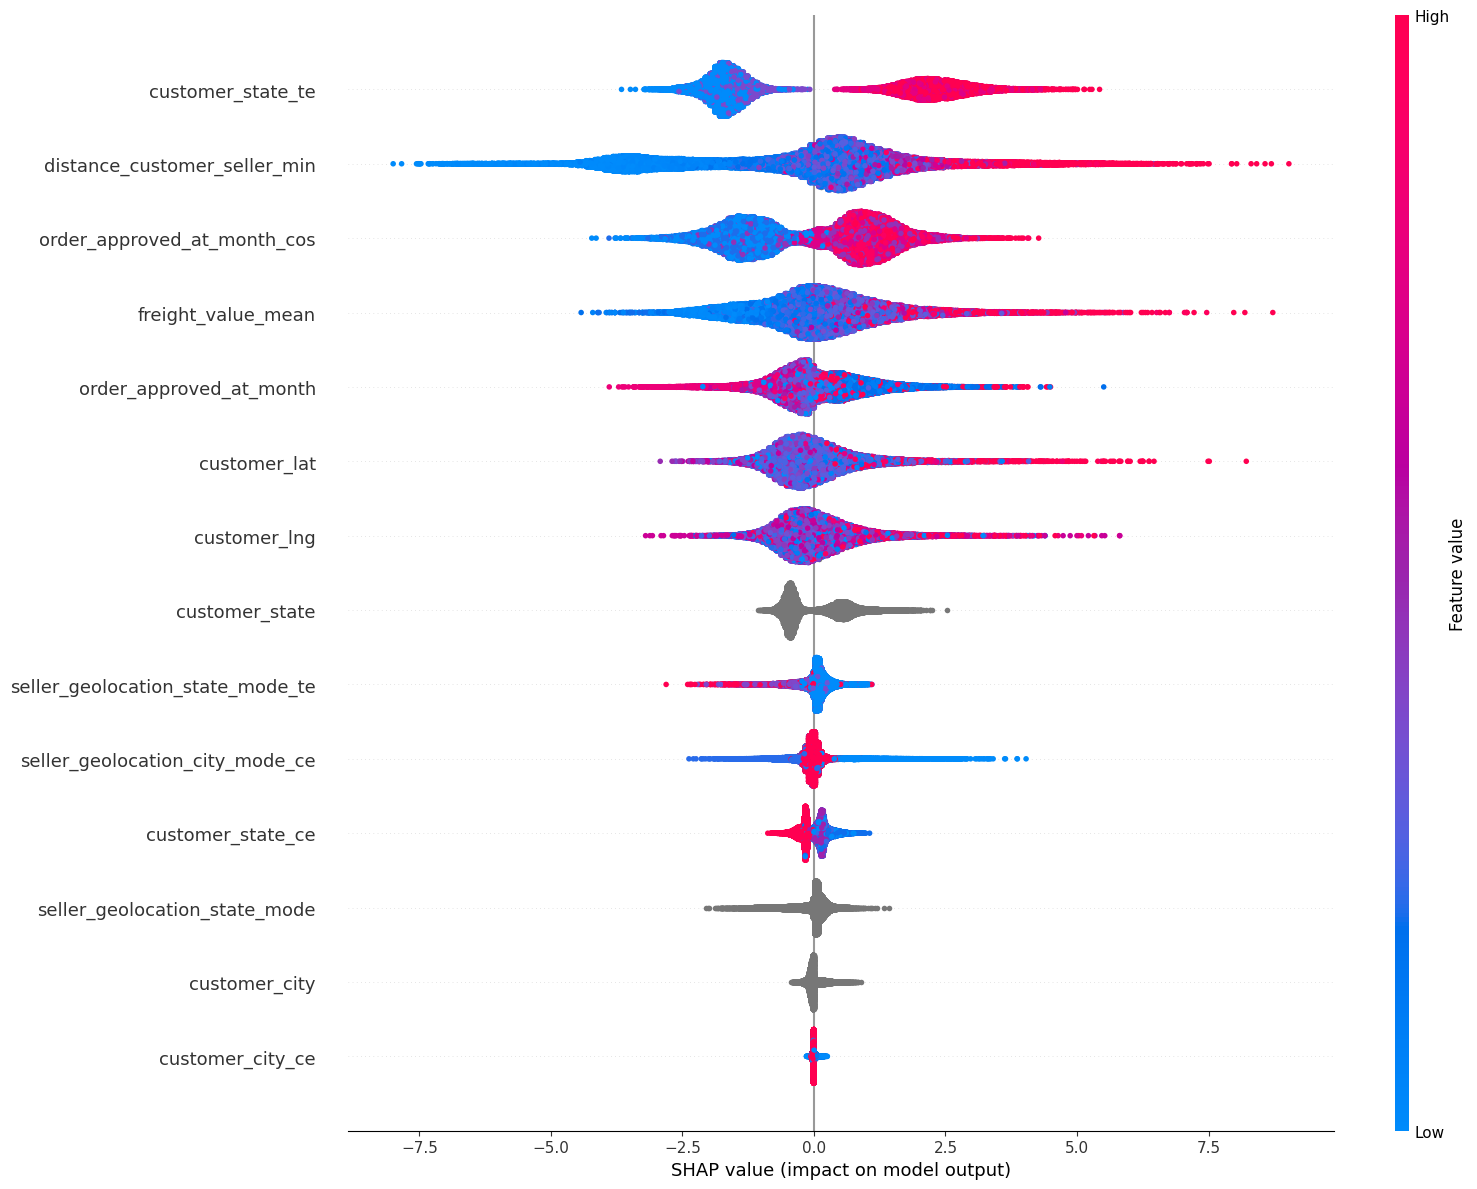

,index,impact
11,customer_state_te,1.944010
5,distance_customer_seller_min,1.578101
13,order_approved_at_month_cos,1.184353
6,freight_value_mean,0.895229
7,order_approved_at_month,0.640833
2,customer_lat,0.583192
3,customer_lng,0.535866
1,customer_state,0.519959
12,seller_geolocation_state_mode_te,0.208832
10,seller_geolocation_city_mode_ce,0.205723


In [97]:
shap.summary_plot(shap_values, X_train[list_selected_features], plot_size=(16, 12))

shap_df = pd.DataFrame(np.abs(shap_values), columns=list_selected_features)
shap_df = (
    pd.DataFrame(shap_df.mean(), columns=["impact"]).reset_index()
    .rename(columns={"level_0": "var"})
    .sort_values(by=["impact"], ascending=False))

display(shap_df.head(15))

## Analysis of Estimated Values

### Train Values

In [99]:
get_metrics(y_train[target], y_train['estimated_delivery_in_days'])

R2: -1.2710958645968153; RMSE: 15.15362181073755; MAE: 12.798987749467994; MAPE: 63632846865898.91


In [100]:
get_metrics(y_train[target], y_train['pred'])

R2: 0.5348968373281158; RMSE: 6.857619076069917; MAE: 4.105505814755573; MAPE: 18690993962939.848


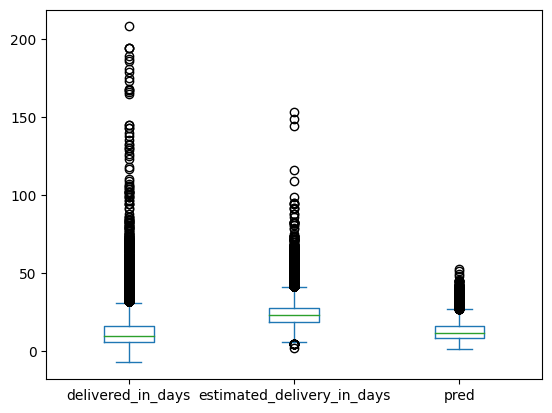

In [101]:
y_train.plot(kind='box');

### Valid Values

In [102]:
get_metrics(y_valid[target], y_valid['estimated_delivery_in_days'])

R2: -1.3023139893957243; RMSE: 14.932066313490298; MAE: 12.686517203798848; MAPE: 58722788228598.95


In [103]:
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.3017741896105808; RMSE: 8.223100217192222; MAE: 5.127473484280988; MAPE: 19567894489053.703


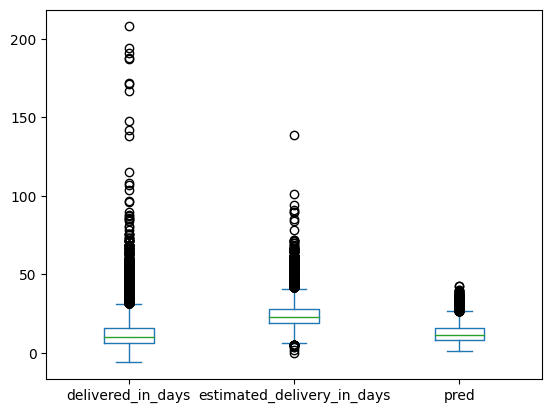

In [104]:
y_valid.plot(kind='box');

### OoT Values

In [105]:
get_metrics(y_oot[target], y_oot['estimated_delivery_in_days'])

R2: -6.096547120243494; RMSE: 15.469371569468713; MAE: 12.755738321776057; MAPE: 243542505248334.34


In [106]:
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.03659353703464929; RMSE: 5.91225795354172; MAE: 4.426038874551464; MAPE: 112669398398553.16


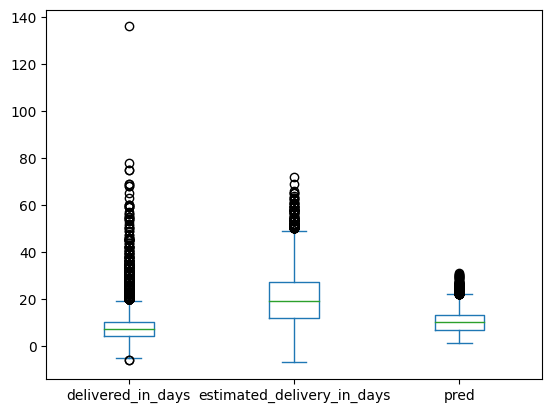

In [107]:
y_oot.plot(kind='box');